
## 데이터의 특징 파악을 위한 탐색적 데이터 분석 자료


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import networkx as nx

# !pip install umap-learn
import umap

In [ ]:
print(f"numpy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"networkx version: {nx.__version__}")
print(f"umap-learn version: {umap.__version__}")

numpy version: 1.21.6
pandas version: 1.3.5
networkx version: 2.6.3
umap-learn version: 0.5.3


## **1. Data 로드**
제공 받은 데이터 파일은 Google Drive에 업로드 하여 분석에 사용했습니다. 
데이터는 총 9개의 CSV 파일로, edge.csv(1), node_feat_xxx.csv(3), node_year_xxx.csv(3), node_label_xxx.csv(2) 로 구성되어 있습니다.

각 데이터의 차원을 통해 파악한 그래프의 특성은 edge의 수는 1166243개이고, node의 수는 학습/검증/시험 각각 90941, 29799, 48603개 입니다. node의 feature 정보를 담고 있는 node_feat_xxx.csv의 컬럼 수는 129로 ID 컬럼과 128개의 feature로 구성되어 있습니다. 이때 128개 feature 컬럼의 dtype은 float64이지만, 모든 컬럼의 값이 float32로도 표현이 가능하기 때문에 타입 변환을 통해 메모리 사용을 줄일 수 있었습니다.

In [ ]:
data_path = "/content/drive/MyDrive/Colab_dataset/kakaobank"

In [ ]:
edge = pd.read_csv(os.path.join(data_path, "edge.csv"), header=None)
train_node = pd.read_csv(os.path.join(data_path, "node_feat_train.csv"))
train_year = pd.read_csv(os.path.join(data_path, "node_year_train.csv"))
train_label = pd.read_csv(os.path.join(data_path, "node_label_train.csv"))

valid_node = pd.read_csv(os.path.join(data_path, "node_feat_valid.csv"))
valid_year = pd.read_csv(os.path.join(data_path, "node_year_valid.csv"))
valid_label = pd.read_csv(os.path.join(data_path, "node_label_valid.csv"))

test_node = pd.read_csv(os.path.join(data_path, "node_feat_test.csv"))
test_year = pd.read_csv(os.path.join(data_path, "node_year_test.csv"))


In [ ]:
print(f"edge df shape: {edge.shape}")
print(f"train_node df shape: {train_node.shape}")
print(f"valid_node df shape: {valid_node.shape}")
print(f"test_node df shape: {test_node.shape}")

edge df shape: (1166243, 2)
train_node df shape: (90941, 129)
valid_node df shape: (29799, 129)
test_node df shape: (48603, 129)


In [ ]:
def reduce_memory(df:pd.DataFrame):
    before = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        if col == "id":
            continue
        c_min = df[col].min()
        c_max = df[col].max()
    
        if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
            df[col] = df[col].astype(np.float16)
        elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
            df[col] = df[col].astype(np.float32)
        else:
            df[col] = df[col].astype(np.float64)

    after = df.memory_usage().sum() / 1024**2
    print(f"memory size reduced {before} -> {after}")
    return df

In [ ]:
train_node = reduce_memory(train_node)
valid_node = reduce_memory(valid_node)
test_node = reduce_memory(test_node)

memory size reduced 89.5035171508789 -> 22.896339416503906
memory size reduced 29.32805633544922 -> 7.502616882324219
memory size reduced 47.834800720214844 -> 12.236900329589844


## **2. 탐색적 데이터 분석**
### **2.1. Node 기준 기본 정보**
해당 데이터에서 node는 논문을 의미하고, edge는 인용에 대한 정보를 담고 있습니다. node는 논문이라는 한 가지 종류만을 나타내고 edge는 방향성을 갖고 있으므로 해당 그래프는 homogeneous directed graph로 볼 수 있습니다.

다음은 학습데이터를 이용하여 발행 연도별 논문의 수와 주제 영역(label) 별 논문의 수를 barplot을 통해 파악해 보았습니다.

발행 연도별 논문의 수는 시간이 흐를 수록 지수적으로 증가함을 볼 수 있었고, label 별 논문의 수 편차가 큼을 확인했습니다.

In [ ]:
min_year, max_year = train_year["0"].min(), train_year["0"].max()+1
min_yid, max_yid = train_label["0"].min(), train_label["0"].max()+1

Text(0.5, 1.0, 'Number of nodes by the label')

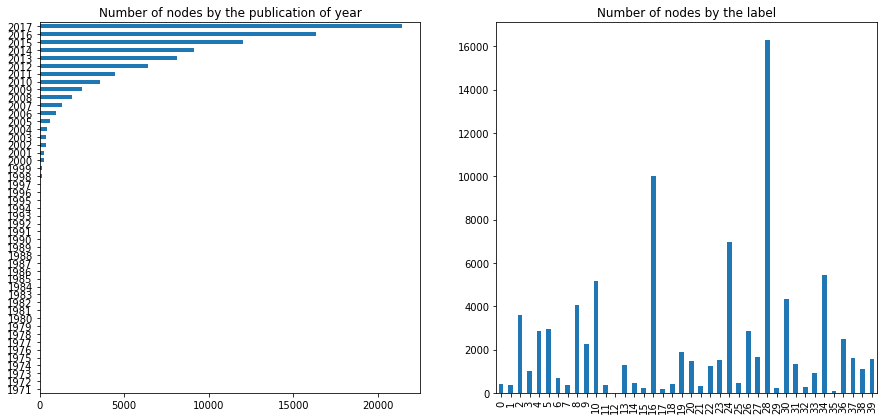

In [ ]:
plt.figure(1)
plt.subplot(2,2,1)
train_year["0"].value_counts().reindex(range(min_year, max_year)).plot(kind='barh', figsize=(15,15))
plt.title("Number of nodes by the publication of year")
plt.subplot(2,2,2)
train_label["0"].value_counts().reindex(range(min_yid, max_yid)).plot(kind='bar', figsize=(15,15))
plt.title("Number of nodes by the label")

### **2.2. Edge의 source, target 구분**
앞 절에서 설명했듯이 edge는 방향성을 갖고 있지만, edge 정보가 있는 dataframe에는 컬럼명이 존재하지 않아 명시적으로 알 수 없습니다. 다만 시기적으로 후에 발행된 논문이 앞서 발행된 논문을 인용한다는 점을 이용하여 해당 dataframe을 구성하는 두 컬럼에 source, target을 부여했습니다.

방법은 하기와 같습니다. 
- year_diff = (첫째 컬럼(노드)의 발행연도 - 둘째 컬럼(노드)의 발행연도)
- year_diff의 분포를 plot을 통해 확인

우선 year_diff 의 histogram을 보았을 때, 대부분 0 이상의 값을 갖지만 일부 음수의 값을 갖는 경우가 있습니다. year_diff의 양수, 음수 그리고 0의 비율을 확인하기 위해 pie chart를 추가로 확인해 보았고, 그 결과 양수(87.1%), 0 (1.8%), 음수(11.1%) 임을 알 수 있었습니다. 음수의 경우 이상치로 고려할 수 있으나, 실제로 발행되지 않은 논문을 인용하는 경우가 있을 수 있다고 판단하였습니다.

이를 통해 edge dataframe의 첫째 컬럼이 후에 발행된 target을 의미하고 둘째 컬럼이 source를 의미한다고 판단하였습니다.

In [ ]:
print(train_year["0"].min(), train_year["0"].max())
print(valid_year["0"].min(), valid_year["0"].max())
print(test_year["0"].min(), test_year["0"].max())

1971 2017
2018 2018
2019 2020


In [ ]:
# year_dict = pd.concat([train_year, valid_year, test_year], axis=0).set_index("id").to_dict()["0"]
year_df = pd.concat([train_year, valid_year, test_year], axis=0)
edge.columns = ["x0", "x1"]

In [ ]:
edge = pd.merge(edge, year_df, how="left", left_on="x0", right_on="id")
edge = pd.merge(edge, year_df, how="left", left_on="x1", right_on="id")
edge = edge.drop(["id_x", "id_y"], axis=1)
edge.columns = ["0", "1", "0_year", "1_year"]

edge["year_diff"] = edge["0_year"] - edge["1_year"]

In [ ]:
def get_diff_code(row):
    if row[4] > 0:
        return "pos"
    elif row[4] == 0:
        return  "zero"
    else:
        return "neg"

edge["year_diff_cls"] = edge.apply(lambda x: get_diff_code(x), axis=1, result_type='expand')

In [ ]:
edge.head(3)

,target,source,target_year,source_year,year_diff,year_diff_cls
0,104447,13091,2011,2008,3,pos
1,15858,47283,2014,2007,7,pos
2,107156,69161,2013,2014,-1,neg


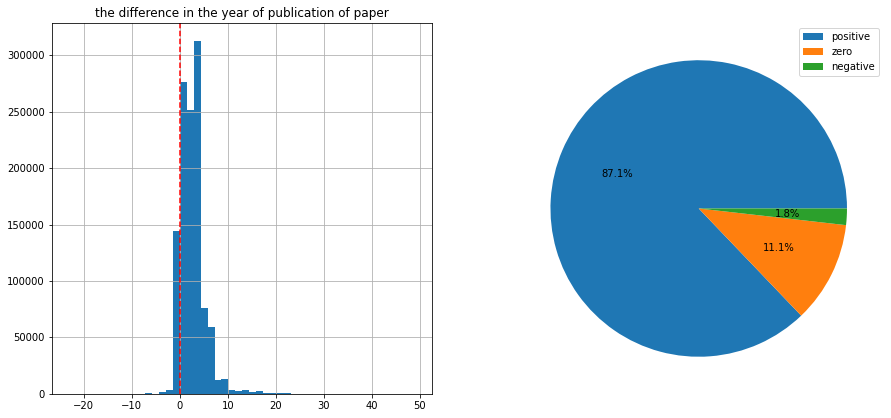

In [ ]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
edge.year_diff.hist(bins=50)
plt.axvline(0, color='red', linestyle='--')
plt.title("the difference in the year of publication of paper")

plt.subplot(2,2,2)
plt.pie(edge.year_diff_cls.value_counts(), autopct='%.1f%%')
plt.legend(["positive", "zero", "negative"], loc="upper right")

In [ ]:
# target, source 부여
edge.columns = ["target", "source", "target_year", "source_year", "year_diff", "year_diff_cls"]
edge = edge.drop(["year_diff_cls"], axis=1)
edge.head()

,target,source,target_year,source_year,year_diff
0,104447,13091,2011,2008,3
1,15858,47283,2014,2007,7
2,107156,69161,2013,2014,-1
3,107156,136440,2013,2013,0
4,107156,107366,2013,2011,2


### **2.3. Node의 degree 분포 분석**
graph의 특성을 파악하는데 있어 가장 기본적인 방법은 node의 degree 분포를 확인하는 것입니다. 다만 분석 대상 graph는 방향성이 있는 directed graph이므로 in-degree와 out-degree를 구분하여 degree 분포를 확인하였습니다.

- in-degree와 out-degree의 의미는 다음과 같이 생각했습니다. 
    - in-degree가 높다: 인용을 많이 했다.
    - out-degree가 높다: 인용이 많이 되었다.

분포를 확인 함에 있어 연산 시간을 줄이기 위해 train, validation, test 데이터 별 각각 1만개의 data를 random sampling 하였습니다.



In [ ]:
seed = 1234
def set_seed(seed:int):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

**2.3.1. Random sampling**

In [ ]:
set_seed(seed)

n_sample = 10000

train_samp = random.sample(train_year["id"].values.tolist(), n_sample)
valid_samp = random.sample(valid_year["id"].values.tolist(), n_sample)
test_samp = random.sample(test_year["id"].values.tolist(), n_sample)

train_edge = edge.loc[edge.target.isin(train_samp), ]
valid_edge = edge.loc[edge.target.isin(valid_samp), ]
test_edge = edge.loc[edge.target.isin(test_samp), ]

print(train_edge.shape)
print(valid_edge.shape)
print(test_edge.shape)

(41594, 5)
(84346, 5)
(111592, 5)


In [ ]:
train_in_degree = train_edge.target.value_counts()
valid_in_degree = valid_edge.target.value_counts()
test_in_degree = test_edge.target.value_counts()

In [ ]:
train_out_degree = train_edge.source.value_counts()
valid_out_degree = valid_edge.source.value_counts()
test_out_degree = test_edge.source.value_counts()

**2.3.2. In/Out degree distribution (train, validation, test) + log transformed distribution**
- degree 분포를 확인하기 위해 density plot을 그렸을 때 in/out degree 분포 모두 우측으로 꼬리가 긴 형태입니다.
- 육안으로 분포를 잘 보기 위해 log 변환을 동시에 진행하였습니다.
- log 변환된 in-degree의 분포를 보면 train에서 validation 그리고 test로 갈 수록 in-degree가 높은 node가 많이 분포함을 알 수 있고, 이는 곧 발행 연도에 따라 발생한 패턴이라고 볼 수 있습니다.
- 반면 out-degree의 경우 train, validation, test 모두 유사한 분포를 보여주고 있습니다.

In [ ]:
def plot_degree_distribution(
    train:pd.DataFrame, valid:pd.DataFrame, test:pd.DataFrame, io:str="In", fs:tuple=(15,8)
    ):

    plt.figure(figsize = fs)
    plt.subplot(2,2,1)
    sns.kdeplot(train, shade=True)
    sns.kdeplot(valid, shade=True)
    sns.kdeplot(test, shade=True)
    plt.title(f"{io}-degree distribution")
    plt.legend(["train", "valid", "test"])

    plt.subplot(2,2,2)
    sns.kdeplot(train.apply(lambda x: np.log(x)), shade=True)
    sns.kdeplot(valid.apply(lambda x: np.log(x)), shade=True)
    sns.kdeplot(test.apply(lambda x: np.log(x)), shade=True)
    plt.title(f"{io}-degree distribution (log-transformed)")
    plt.legend(["train", "valid", "test"])

    plt.show()

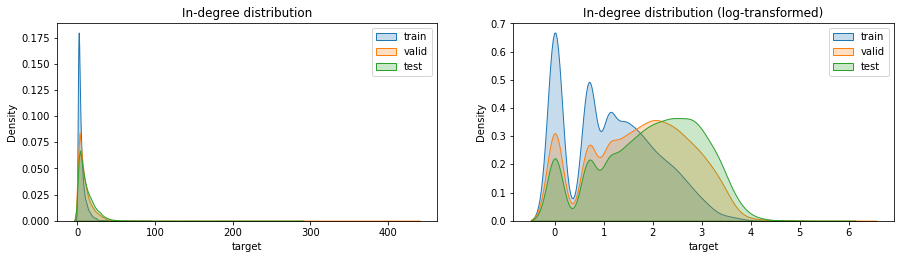

In [ ]:
plot_degree_distribution(train_in_degree, valid_in_degree, test_in_degree, "In")

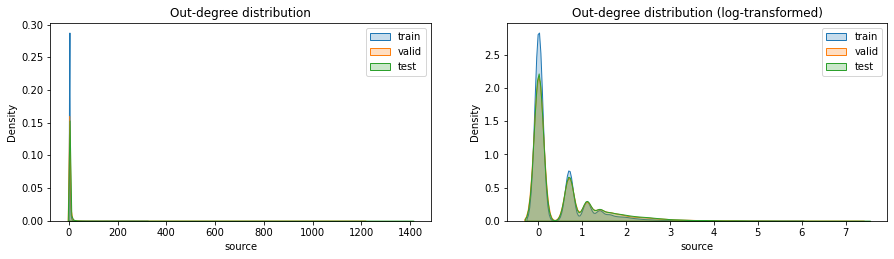

In [ ]:
plot_degree_distribution(train_out_degree, valid_out_degree, test_out_degree, "Out")

**2.3.3. Node 별 in/out degree 수를 Label 별로 평균내어 분포 확인**
- 각 Node 별 in/out degree 분포를 앞 절에서 확인해 보았습니다.
- 이때 각 node를 label 별로 그룹화하여 특징을 살펴보았습니다.

label 별 평균 in/out degree를 barplot을 통해 확인한 결과, 특정 label에서 눈에 띄게 높은 수치를 갖는 것을 알 수 있습니다. 이를 통해 분류 모형을 구축할 때 graph 특성을 고려할 수 있는 방법이 알맞을 수 있다는 직관을 얻었습니다.

In [ ]:
train_in_degree.head()

110238    92
134632    55
38761     51
163213    49
107569    49
Name: target, dtype: int64

In [ ]:
cls_in_degree = pd.merge(train_in_degree.reset_index(), train_label, how="inner", left_on="index", right_on="id")
cls_in_degree.columns = ["target_id", "cnt", "id", "label"]
cls_in_degree = cls_in_degree.drop(["id"], axis=1)

cls_in_degree.head(3)

,target_id,cnt,label
0,110238,92,30
1,134632,55,16
2,38761,51,31


In [ ]:
cls_out_degree = pd.merge(train_out_degree.reset_index(), train_label, how="inner", left_on="index", right_on="id")
cls_out_degree.columns = ["target_id", "cnt", "id", "label"]
cls_out_degree = cls_out_degree.drop(["id"], axis=1)

cls_out_degree.head(3)

,target_id,cnt,label
0,25208,322,16
1,1353,299,24
2,67166,245,16


  - *16번 클래스의 평균 in-degree가 약 10으로 높고, 이후로는 30번(6.6), 24번(5.8), 28(5.7)번 클래스의 평균 in-degree가 높습니다*
  - *in-degree와 마찬가지로 16번 클래스의 평균 out-degree(3.9)가 높고, 이후 13번(3.5), 30번(3.2), 24번(2.8) 클래스의 평균 out-degree가 높습니다*

Text(0.5, 1.0, 'Average of the number of out-degree by the label')

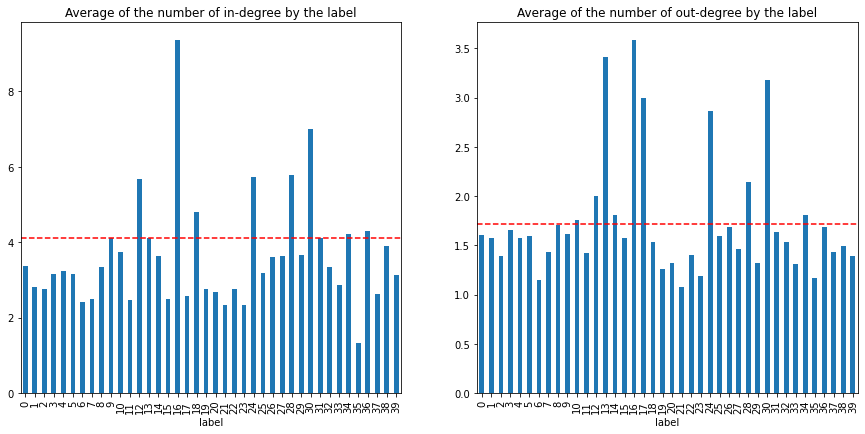

In [ ]:
q3_i = np.quantile(cls_in_degree.groupby(["label"])["cnt"].mean(), 0.75)
q3_o = np.quantile(cls_out_degree.groupby(["label"])["cnt"].mean(), 0.75)

plt.figure(figsize = (15,15))
plt.subplot(2,2,1)
cls_in_degree.groupby(["label"])["cnt"].mean().plot(kind='bar')
plt.axhline(q3_i, color='red', linestyle='--')
plt.title("Average of the number of in-degree by the label")

plt.subplot(2,2,2)
cls_out_degree.groupby(["label"])["cnt"].mean().plot(kind='bar')
plt.axhline(q3_o, color='red', linestyle='--')
plt.title("Average of the number of out-degree by the label")

**2.3.4. source node와 연결된 node들의 purity 계산하여 발행연도 및 클래스 별 분포 확인**
- source node와 연결되어 있는 node들의 label 정보를 이용하여 purity라는 지표를 계산했습니다.
- purity는 (source node와 연결된 동일한 label의 node 수 / source node의 out-degree) 로 계산하였습니다.
- 이후 계산된 purity 정보를 발행연도 및 label 별로 boxplot을 그려 특징을 파악해 보았습니다.

In [ ]:
edge = pd.merge(edge, train_label, how="left", left_on="source", right_on="id")
edge = pd.merge(edge, train_label, how="left", left_on="target", right_on="id")
edge = edge.drop(["id_x", "id_y"], axis=1)
edge.columns = ["target", "source", "target_year", "source_year", "year_dff", "source_label", "target_label"]
edge.head(3)

,target,source,target_year,source_year,year_dff,source_label,target_label
0,104447,13091,2011,2008,3,6.0,6.0
1,15858,47283,2014,2007,7,34.0,16.0
2,107156,69161,2013,2014,-1,23.0,5.0


In [ ]:
train_edge = edge.dropna()

purity = []
sources = train_edge.source.unique()
for s in sources:
    tmp = train_edge.loc[train_edge.source == s, ]#.dropna()
    bin = [1 if t["source_label"]==t["target_label"] else 0 for _, t in tmp.iterrows()]
    if len(bin)>0:
        purity.append([s, sum(bin)/len(bin)])

In [ ]:
purity_df = pd.DataFrame(purity)
purity_df.columns = ["id", "purity"]
purity_df.head()

,id,purity
0,13091,1.000000
1,47283,0.053156
2,69161,0.040000
3,136440,0.210526
4,107366,0.555556


In [ ]:
train_edge = pd.merge(train_edge, purity_df, how="left", left_on="source", right_on="id")
train_edge[["source_label", "target_label"]] = train_edge[["source_label", "target_label"]].astype(int)
train_edge = train_edge.drop(["id"], axis=1)
train_edge.head()

,target,source,target_year,source_year,year_dff,source_label,target_label,purity
0,104447,13091,2011,2008,3,6,6,1.000000
1,15858,47283,2014,2007,7,34,16,0.053156
2,107156,69161,2013,2014,-1,23,5,0.040000
3,107156,136440,2013,2013,0,8,5,0.210526
4,107156,107366,2013,2011,2,28,5,0.555556


In [ ]:
ts_purity = train_edge.groupby("source_year")["purity"].mean().reset_index()
ts_purity.head()

,source_year,purity
0,1971,0.185185
1,1986,1.000000
2,1987,0.666667
3,1988,1.000000
4,1990,0.530303


In [ ]:
label_purity = train_edge.groupby("source_label")["purity"].mean().reset_index()
label_purity.head()

,source_label,purity
0,0,0.176072
1,1,0.305215
2,2,0.637188
3,3,0.265851
4,4,0.608575


- *발행연도 별 purity의 분포를 보았을 때 평균적으로 유의미한 차이가 없는 것으로 보입니다.*

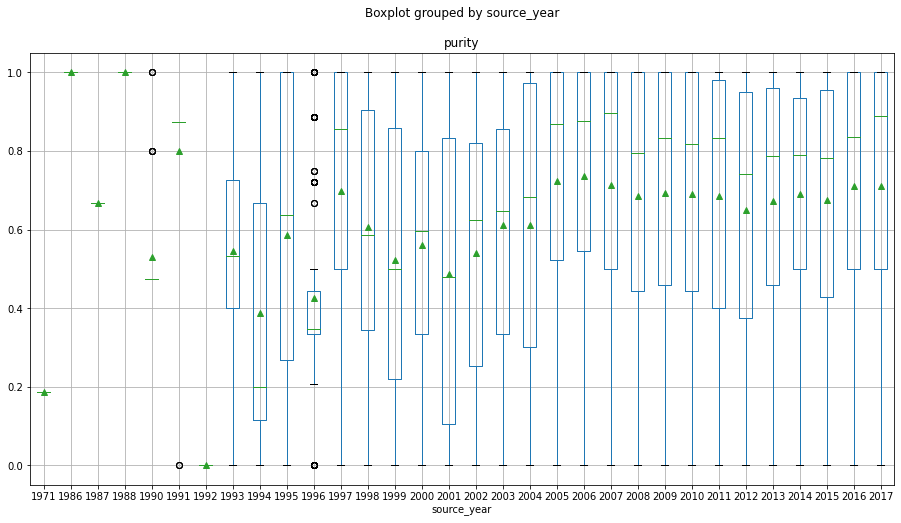

In [ ]:
train_edge.boxplot(column="purity", by="source_year", figsize=(15,8), showmeans=True)

- *label 별 purity의 분포를 보았을 때 일부 label 간 평균적으로 유의미한 차이가 있는 그룹이 있는 것으로 보입니다.*
- *이를 통해 2.3.3 절과 마찬가지로 graph의 구조적 특징이 label을 분류하는데 중요할 수 있다는 직관을 얻었습니다.*

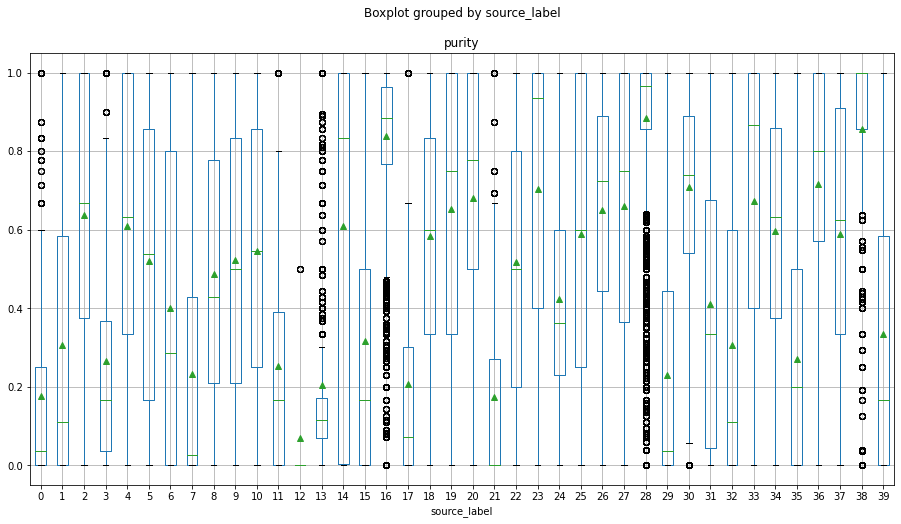

In [ ]:
train_edge.boxplot(column="purity", by="source_label", figsize=(15,8), showmeans=True)

**2.3.5. self loop 존재하는 지 확인**
- 자기 자신을 인용하는 이상치 케이스가 존재하는 지 확인해보았고, self-loop는 존재하지 않음을 확인했습니다.

In [ ]:
self_loop = [1 if d.target==d.source else 0 for _,d in edge.iterrows()]
sum(self_loop)

0

###**2.4. networkx를 이용한 중심성(centrality) 지표 확인**
node의 특성을 추가적으로 확인하기 위해 degree centrality와 eigenvector centrality 지표를 발행연도 별로 확인했습니다.

약 2010년도 이후 중심성 지표가 높은 node들이 등장함을 알 수 있었습니다.

In [ ]:
G = nx.from_pandas_edgelist(edge, 'source', 'target')

In [ ]:
deg_cen = nx.degree_centrality(G)
eigen_cen = nx.eigenvector_centrality(G)

In [ ]:
year_df = pd.concat([train_year, valid_year, test_year], axis=0)
year_df.columns = ["id", "year"]
year_df.shape

(169343, 2)

In [ ]:
year_df["degree_centrality"] = year_df.apply(lambda x: deg_cen[x["id"]], axis=1)
year_df["eigenv_centrality"] = year_df.apply(lambda x: eigen_cen[x["id"]], axis=1)
year_df.head()

,id,year,degree_centrality,eigenv_centrality
0,0,2013,0.001718,4.012020e-03
1,1,2015,0.000012,1.533451e-11
2,2,2014,0.000083,1.568898e-06
3,3,2014,0.000012,1.569147e-11
4,4,2014,0.000035,9.746448e-07


- *boxplot의 분포를 보았을 때, 평균적으로 유의한 차이는 없지만, 이상치로 보이는 data의 편차가 2007년도 이후 점차 커짐을 볼 수 있습니다.*

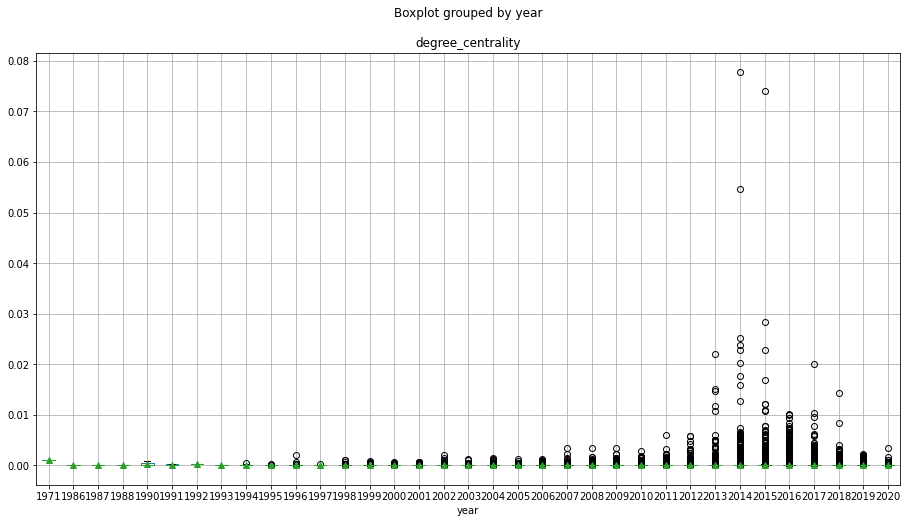

In [ ]:
year_df.boxplot(column="degree_centrality", by="year", figsize=(15,8), showmeans=True)

- *위 boxplot과 유사한 특징을 보이고 있습니다.*

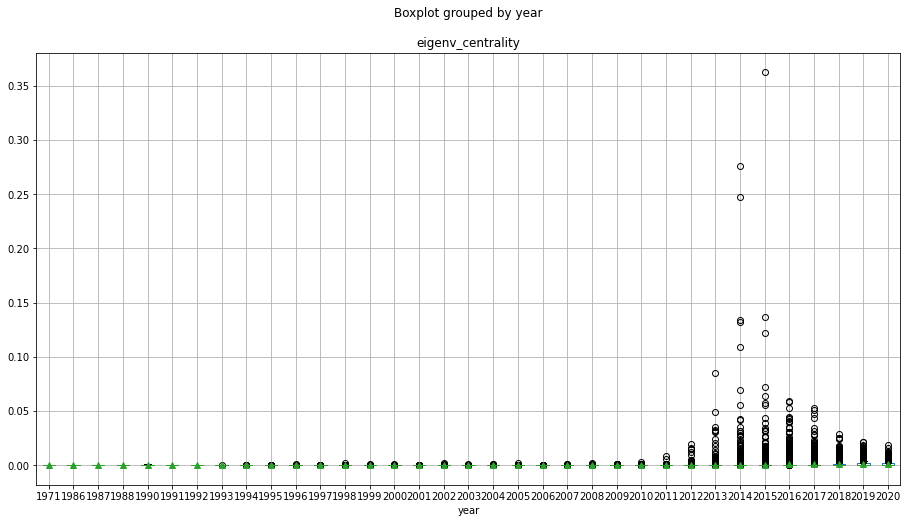

In [ ]:
year_df.boxplot(column="eigenv_centrality", by="year", figsize=(15,8), showmeans=True)

###**2.5 node feature 분석**
각 node는 논문의 제목과 초록에 사용된 단어 내에서 추출된 128개의 feature가 있습니다.

단순히 해당 feature가 label을 분류하기 위해 어느 정도의 정보를 담고 있는지 확인해보고, 이에 vector space model을 적용했을 때 성능을 가늠잡아 보기 위해 feature embedding을 진행했습니다.

적용한 방법은 manifold learning 방법 중 하나인 UMAP을 이용하여 2차원 공간에 embedding을 시켰고, 이를 시각화를 했습니다. UMAP을 사용할 때 연산 시간을 줄이 기 위해 train, validation 데이터를 각각 30% random sampling하여 사용했습니다.

train, validation 데이터의 embedding을 시각화한 scatter plot을 보았을 때, 
일부 label의 data는 분류가 가능해보이나 전체적으로는 label 구분 없이 뭉쳐 있음을 알 수 있습니다. 

In [ ]:
import gc

del edge, train_edge, label_purity, ts_purity
gc.collect()

462

In [ ]:
train_node.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90941 entries, 0 to 90940
Columns: 129 entries, id to 127
dtypes: float16(128), int64(1)
memory usage: 22.9 MB


In [ ]:
train_node.head()

,id,0,1,2,3,4,5,6,7,8,...,118,119,120,121,122,123,124,125,126,127
0,0,-0.057953,-0.052521,-0.072632,-0.026550,0.130493,-0.241333,-0.449219,-0.018448,-0.087219,...,0.211548,-0.226074,-0.185547,0.053223,0.332764,0.104187,0.007408,0.173340,-0.172852,-0.140015
1,1,-0.124512,-0.070679,-0.325195,0.007778,-0.001559,0.074219,-0.191040,0.049683,0.026367,...,0.106323,0.052917,-0.258301,0.021561,0.281494,-0.173462,0.202026,0.068542,-0.372070,-0.301025
2,2,-0.080261,-0.023331,-0.183838,-0.180664,0.075745,-0.125854,-0.394531,-0.219116,-0.108948,...,0.019455,-0.070312,-0.177612,-0.213989,0.182129,-0.121582,-0.073669,0.109924,0.117615,-0.139893
3,3,-0.145020,0.054901,-0.126709,0.039978,-0.055908,-0.101257,-0.339111,-0.115784,-0.080078,...,-0.065735,0.042725,0.066345,-0.226929,0.188477,-0.017288,0.063477,0.017822,0.085388,-0.081787
4,4,-0.071167,0.070740,-0.281494,-0.161865,-0.165283,-0.029114,-0.338623,-0.138672,0.100037,...,-0.056122,0.047485,-0.263916,0.026459,0.376465,-0.253662,0.084473,0.098022,-0.075317,-0.111694


In [ ]:
set_seed(seed)

sample_rate = 0.3
train_sample_size = int(train_node.shape[0] * sample_rate)
valid_sample_size = int(valid_node.shape[0] * sample_rate)

train_sampl_idx = random.sample(range(train_node.shape[0]), train_sample_size)
valid_sampl_idx = random.sample(range(valid_node.shape[0]), valid_sample_size)

print(f"train data size {train_node.shape[0]} -> {train_sample_size}")
print(f"valid data size {valid_node.shape[0]} -> {valid_sample_size}")

train data size 90941 -> 27282
valid data size 29799 -> 8939


In [ ]:
train_node = train_node.loc[train_sampl_idx, ].reset_index(drop=True)
valid_node = valid_node.loc[valid_sampl_idx, ].reset_index(drop=True)

train_label = train_label.loc[train_sampl_idx, ].reset_index(drop=True)
valid_label = valid_label.loc[valid_sampl_idx, ].reset_index(drop=True)

print(f"train node size : {train_node.shape} and valid node size : {valid_node.shape}")

train node size : (27282, 129) and valid node size : (8939, 129)


In [ ]:
train_node = train_node.set_index("id")
valid_node = valid_node.set_index("id")

In [ ]:
n = 300
md = 0.15

In [ ]:
%%time

manifold = umap.UMAP(n_neighbors=n, min_dist=md, random_state=seed).fit(train_node)

train_embd = manifold.transform(train_node)
# train_embd = pd.DataFrame(train_embd)

CPU times: user 5min 45s, sys: 7.59 s, total: 5min 53s
Wall time: 4min 5s


In [ ]:
%%time 

valid_embd = manifold.transform(valid_node)
# valid_embd = pd.DataFrame(valid_embd)

CPU times: user 4min 28s, sys: 7.86 s, total: 4min 36s
Wall time: 4min 26s


- *3시 방향의 노란색 data point와 10시 방향의 연두색 data point는 label 기준 cluster를 형성한 듯 보이나 이외 data point는 무작위로 섞여있는 형태입니다*

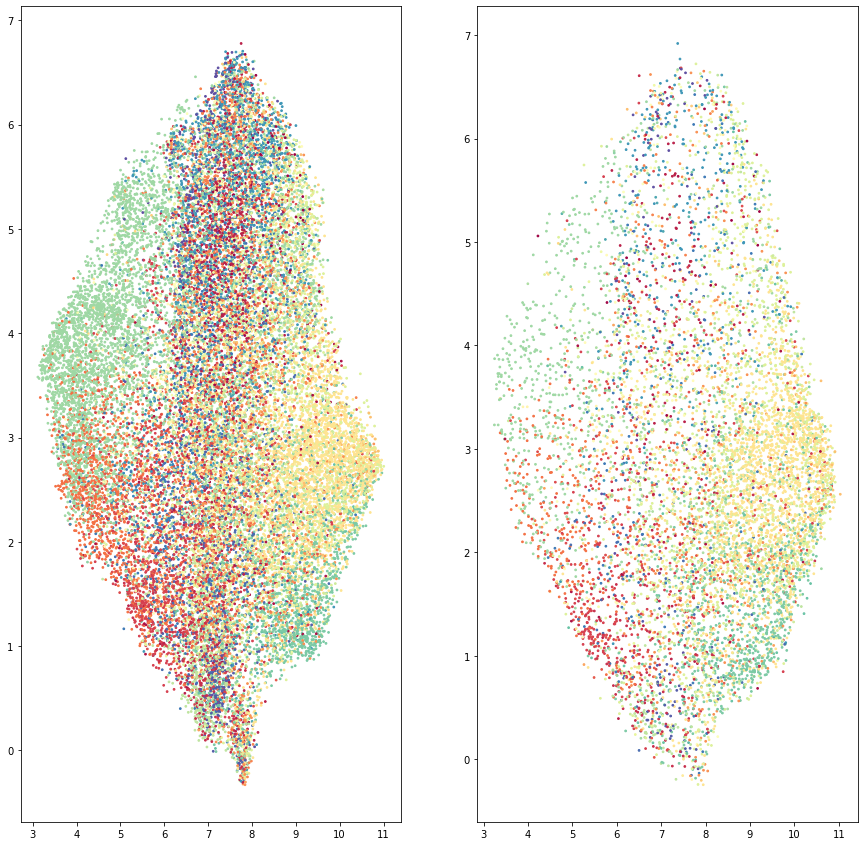

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,15))

ax[0].scatter(train_embd[:, 0], train_embd[:, 1], c=train_label["0"], s=3, cmap='Spectral')
ax[1].scatter(valid_embd[:, 0], valid_embd[:, 1], c=valid_label["0"], s=3, cmap='Spectral')